In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
from nltk import pos_tag, pos_tag_sents
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


In [2]:
file = pd.read_csv('../Campaign Type.csv', sep='|')
file = file.loc[:,['Campaign','Product Type','Subject Line','Sent','Unique Open','Unique Click']]
file.columns = ['campaign', 'prod_type', 'subject', 'sent', 'uniq_open', 'uniq_click']

In [3]:
file['openrate%'] = 100*(file['uniq_open'] / file['sent'])
file['clickrate%'] = 100*(file['uniq_click'] / file['sent'])

In [4]:
def count_pos(df, pos_type):
    nouns = ['NN','NNS','NNP','NNPS']
    verbs = ['VB','VBD','VBG','VBN','VBP','VBZ']
    adverbs = ['RB','RBR','RBS']
    adjectives = ['JJ','JJR','JJS']
    
    d = dict(pos_tag(df['subject'].split(',')))
    pos_values = list(d.values())
    cnt = 0
    
    if pos_type == 'noun':
        for each in pos_values:
            if each in nouns:
                cnt += 1
    elif pos_type == 'verb':
        for each in pos_values:
            if each in verbs:
                cnt += 1
    elif pos_type == 'adv':
        for each in pos_values:
            if each in adverbs:
                cnt += 1
    elif pos_type == 'adj':
        for each in pos_values:
            if each in adjectives:
                cnt += 1
    else:
        pass
    return cnt

class processing(TransformerMixin):
    """
    [mandatory] make sure the df has 'subject' field
    [optional] 'campaign' and/or 'prod_type' fields
    """
    def __init__(self, df):
        self.df = df
        
    def fit(self, *_):
        return self
    
    def transform(df, *_):
        stop_words = set(stopwords.words('english'))

        df['subject'] = df['subject'].apply(''.join).str.replace('[^A-Za-z\d!?\s]+', '').str.split(expand=False)
        df['subject'] = df['subject'].apply(lambda x: ','.join([w for w in x if not w in stop_words]))

        df.loc[:, 'word_count'] = df.apply(lambda x: len(x['subject'].split(',')), axis = 1)
        df.loc[:, 'char_len'] = df.apply(lambda x: len(x['subject']), axis = 1)
        df.loc[:, 'avg_word_len'] = df['char_len'] / df['word_count']
        df.loc[:, 'mentioned_amt'] = df.apply(lambda x: len(re.findall("Rs\d+", x['subject'])), axis = 1)
        df.loc[:, 'mentioned_Indus'] = df.apply(lambda x: len(re.findall("indus*", x['subject'].lower())), axis = 1)
        df.loc[:, 'nouns'] = df.apply(lambda x: count_pos(x, pos_type='noun'), axis = 1)
        df.loc[:, 'verbs'] = df.apply(lambda x: count_pos(x, pos_type='verbs'), axis = 1)
        df.loc[:, 'adverbs'] = df.apply(lambda x: count_pos(x, pos_type='adverbs'), axis = 1)
        df.loc[:, 'adjectives'] = df.apply(lambda x: count_pos(x, pos_type='adjectives'), axis = 1)

        df = df.drop(['char_len'], axis = 1)

        le = LabelEncoder()
        cols = list(df.columns)
        if 'campaign' in cols:
            df['campaign'] = le.fit_transform(df['campaign'])
        if 'prod_type' in cols:
            df['prod_type'] = le.fit_transform(df['prod_type'])

    #     df = df.drop_duplicates()

        return df

In [5]:
def get_doc(df):
        df = df[['subject']]
        taggeddoc = []
        texts = []

        for i, row in file.iterrows():
            #for tagged doc
            wordslist = []
            tagslist = []

            td = TaggedDocument(gensim.utils.to_unicode(str.encode(row['subject'])).split(','), [str(i)])
            taggeddoc.append(td)
        return taggeddoc

    
class d2vEmbedding(TransformerMixin):
    """
    sentence embedding - currently doc2vec
    [mandatory] make sure df has 'subject' field
    """
    def __init__(self, df):
        self.df = df
        
    def fit(self, *_):
        return self

    def transform(df, *_):
        documents = get_doc(df)

        vec_dim_size = 20
        d2v = Doc2Vec(documents=documents, dm = 0, alpha=0.025, size=vec_dim_size, min_alpha=0.025, min_count=1)

        for epoch in range(200):
            if epoch % 20 == 0:
                print('...training epoch %s'%epoch)
            d2v.train(documents, total_examples = len(documents), epochs=1)
            d2v.alpha -= 0.002 # decreasing the lr
            d2v.min_alpha = d2v.alpha # fix the lr, no decay

        sub_d2v_df = pd.DataFrame(d2v.docvecs.vectors_docs)
        cols = ['s'+str(i) for i in range(vec_dim_size)]
        sub_d2v_df.columns = cols

        tmp_df = df.drop(['subject','sent','uniq_open','uniq_click','clickrate%'], axis = 1)
        df_cols = list(tmp_df.columns)
        if 'campaign' in df_cols: # remove 'campaign' col (if present)
            tmp_df = tmp_df.drop(['campaign'], axis = 1)
        if 'prod_type' in df_cols: # remove 'prod_type' col (if present)
            tmp_df = tmp_df.drop(['prod_type'], axis = 1)

        #concat d2v df and processed df
        sub_df = pd.concat([sub_d2v_df, tmp_df], axis = 1)

        return sub_df

In [6]:
# load word vectors of wiki data
# create sentence embeddings of subject lines (avg out w2v vectors)
# re-train regressor and predict

import time
from gensim.models import KeyedVectors

class sentEmbedding(TransformerMixin):
    def __init__(self, df):
        self.df = df
    
    def fit(self, *_):
        return self
    
    def transform(df, *_):
        st = time.time()
        
        en_model = KeyedVectors.load_word2vec_format('wiki_model_v1.vec')
        
        et = time.time()
        print("wiki model took {:.2f} minutes to load".format((et-st)/60))
        
        #Getting the tokens 
        words = []
        for word in en_model.vocab:
            words.append(word)
        
        D = df[['subject']].copy()
        D['subject'] = D['subject'].apply(lambda x: x.lower().replace('[^A-Za-z\s]+',''))
        D['subject'] = D['subject'].apply(lambda x: re.sub('\d+','', x))
        cols = ['v'+str(i) for i in range(100)]
        for col in cols:
            D[col]= 0.0 #pre-fill columns 0 to 99 as w2v dim is 100
        
        for idx, row in D.iterrows():
            #generate avg of w2v of vectors of each word in each subject
            D.loc[idx, cols] = np.mean([en_model.wv[w] for w in row['subject'] if w in words] or [np.zeros(100)], axis=0)
        
        tmp_D = D.drop(['subject'], axis = 1)
        tmp_df = df.drop(['campaign','prod_type','subject','sent','uniq_open','uniq_click','clickrate%'], axis = 1)
        F = pd.concat([tmp_D, tmp_df], axis = 1)
        
        return F

In [7]:
class sentEmbeddingOnly(TransformerMixin):
    def __init__(self, df):
        self.df = df
    
    def fit(self, *_):
        return self
    
    def transform(df, *_):
        st = time.time()
        
        en_model = KeyedVectors.load_word2vec_format('wiki_model_v1.vec')
        
        et = time.time()
        print("wiki model took {:.2f} minutes to load".format((et-st)/60))
        
        #Getting the tokens 
        words = []
        for word in en_model.vocab:
            words.append(word)
        
        D = df[['subject']].copy()
        D['subject'] = D['subject'].apply(lambda x: x.lower().replace('[^A-Za-z\s]+',''))
        D['subject'] = D['subject'].apply(lambda x: re.sub('\d+','', x))
        cols = ['v'+str(i) for i in range(100)]
        for col in cols:
            D[col]= 0.0 #pre-fill columns 0 to 99 as w2v dim is 100
        
        for idx, row in D.iterrows():
            #generate avg of w2v of vectors of each word in each subject
            D.loc[idx, cols] = np.mean([en_model.wv[w] for w in row['subject'] if w in words] or [np.zeros(100)], axis=0)
        
        tmp_D = D.drop(['subject'], axis = 1)
        tmp_df = df[['openrate%']]
        F = pd.concat([tmp_D, tmp_df], axis = 1)
        
        return F

In [8]:
class splitter(TransformerMixin):
    
    def __init__(self, df):
        self.df = df
    
    def fit(self, *_):
        return self
    
    def transform(df, *_):
        X = df.drop(['openrate%'], axis = 1)
        y = df[['openrate%']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        return X_train, X_test, y_train, y_test

In [9]:
# pipeline with doc2vec sentence embedding
pipe = Pipeline([('processing', processing),
                 ('embedding', d2vEmbedding),
                 ('splitter', splitter)])

# pipeline with sentence embeddings from word2vec model trained on wiki's data
pipe2 = Pipeline([('processing', processing),
                 ('embedding', sentEmbedding),
                 ('splitter', splitter)])

# pipeline with just sentence embeddings as features from word2vec trained on wiki's data
pipe3 = Pipeline([('processing', processing),
                 ('embedding', sentEmbeddingOnly),
                 ('splitter', splitter)])


### using doc2vec sentence embeddings 

In [10]:
st = time.time()

R = pipe.transform(file)
X_train, X_test, y_train, y_test = R

print("whole pipeline took {:.2f} minutes".format((time.time()-st)/60))

...training epoch 0
...training epoch 20
...training epoch 40
...training epoch 60
...training epoch 80
...training epoch 100
...training epoch 120
...training epoch 140
...training epoch 160
...training epoch 180
whole pipeline took 1.55 minutes


Training set score: 0.85
Test set score: 0.08
------------------------------
MSE: 0.033761973498295975
------------------------------


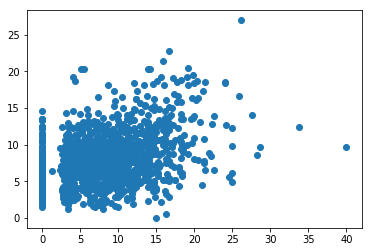

,features,feature_imp
21,avg_word_len,0.145102
24,nouns,0.088387
20,word_count,0.067526
14,s14,0.049386
10,s10,0.048998
7,s7,0.044765
17,s17,0.038632
13,s13,0.037193
18,s18,0.037111
8,s8,0.036779


In [11]:
rfr = RandomForestRegressor(n_estimators=10)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print("Training set score: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, y_test)))
print('-'*30)
print("MSE: {}".format(np.mean(y_test.values - y_pred.ravel()) ** 2))
print('-'*30)

plt.scatter(y_test, y_pred)
plt.show()

features = X_train.columns.tolist()

feat_imp = pd.DataFrame({"features": features, "feature_imp": rfr.feature_importances_}).sort_values("feature_imp", ascending=False)
feat_imp.head(10)

### using sentence embeddings drived from wiki's word2vec model

In [12]:
st = time.time()

R2 = pipe2.transform(file)
X_train2, X_test2, y_train2, y_test2 = R2

print("whole pipeline took {:.2f} minutes".format((time.time()-st)/60))

wiki model took 7.63 minutes to load
whole pipeline took 10.64 minutes


Training set score: 0.32
Test set score: 0.26
------------------------------
MSE: 0.012766386898146633
------------------------------


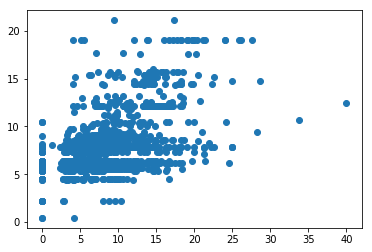

,features,feature_imp
77,v77,0.305917
38,v38,0.082326
68,v68,0.060512
92,v92,0.045946
78,v78,0.044742
53,v53,0.043863
59,v59,0.037447
101,avg_word_len,0.032636
5,v5,0.020213
86,v86,0.019398


In [13]:
rfr = RandomForestRegressor(n_estimators=10)

rfr.fit(X_train2, y_train2)
y_pred2 = rfr.predict(X_test2)

print("Training set score: {:.2f}".format(rfr.score(X_train2, y_train2)))
print("Test set score: {:.2f}".format(rfr.score(X_test2, y_test2)))
print('-'*30)
print("MSE: {}".format(np.mean(y_test2.values - y_pred2.ravel()) ** 2))
print('-'*30)

plt.scatter(y_test2, y_pred2)
plt.show()

features = X_train2.columns.tolist()

feat_imp = pd.DataFrame({"features": features, "feature_imp": rfr.feature_importances_}).sort_values("feature_imp", ascending=False)
feat_imp.head(10)

### using just sentence embedding as features derived from word2vec model trained on wiki's data

In [14]:
st = time.time()

R3 = pipe3.transform(file)
X_train3, X_test3, y_train3, y_test3 = R3

print("whole pipeline took {:.2f} minutes".format((time.time()-st)/60))

wiki model took 7.69 minutes to load
whole pipeline took 10.70 minutes


Training set score: 0.32
Test set score: 0.26
------------------------------
MSE: 0.0032124806147054213
------------------------------


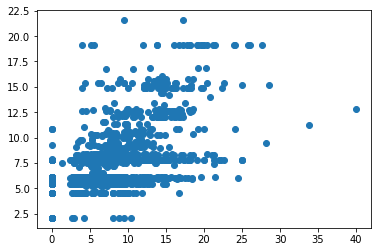

,features,feature_imp
77,v77,0.370639
38,v38,0.093880
68,v68,0.089796
92,v92,0.089347
86,v86,0.017645
25,v25,0.017430
36,v36,0.017311
59,v59,0.016933
5,v5,0.016908
90,v90,0.014890


In [15]:
rfr = RandomForestRegressor(n_estimators=10)

rfr.fit(X_train3, y_train3)
y_pred3 = rfr.predict(X_test3)

print("Training set score: {:.2f}".format(rfr.score(X_train3, y_train3)))
print("Test set score: {:.2f}".format(rfr.score(X_test3, y_test3)))
print('-'*30)
print("MSE: {}".format(np.mean(y_test3.values - y_pred3.ravel()) ** 2))
print('-'*30)

plt.scatter(y_test3, y_pred3)
plt.show()

features = X_train3.columns.tolist()

feat_imp = pd.DataFrame({"features": features, "feature_imp": rfr.feature_importances_}).sort_values("feature_imp", ascending=False)
feat_imp.head(10)